In [ ]:
#library imports
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

#downloading stopwords and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
	

In [ ]:
%pip install lda
%pip install gensim
%pip install seaborn
%pip install pyldavis

In [ ]:
# read the data from the files that has been saved in the web scraping phase
df_jobs = pd.read_csv('Indeed_data_small.csv')
job_description = open('JD.txt').read().split('\n BREAKS HERE')
job_description = job_description[:-1]
english_stopwords = nltk.corpus.stopwords.words('english')
print(len(job_description))
print(len(df_jobs))
print(type(job_description[0]))

In [ ]:
#Tokenization and Lemmatization
def tokenization_and_lemmatization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in english_stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma = [wordnet_lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lemma


def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in english_stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [ ]:
tokenization_and_lemmatization("3+ years in analytics experience solving real-world business problems or doing analytics/data science research")

In [ ]:
docs_lemma = []
docs_tokenized = []
for s in job_description:
    s = s.encode()
    s = s.decode('utf-8')
    docs_lemma.extend(tokenization_and_lemmatization(s))
    tokenized_results = tokenization(s)
    docs_tokenized.extend(tokenized_results)

In [ ]:
vocab_frame_dict = {docs_lemma[x]:docs_tokenized[x] for x in range(len(docs_lemma))}
print(vocab_frame_dict)

In [ ]:
#TF-IDF
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_lemmatization, ngram_range=(1,1))
tfidf_matrix = tfidf_model.fit_transform(job_description) #fit the vectorizer to job description

print("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " job postings and " + str(tfidf_matrix.shape[1]) + " terms.")

In [ ]:
tf_selected_words = tfidf_model.get_feature_names_out()
print(tf_selected_words)

In [ ]:
#Now we use synopses to build a 100*551 matrix (terms)
from sklearn.decomposition import LatentDirichletAllocation

tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)


In [ ]:
# Coherence model
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
n_top_words = 30
dataset = [d.split() for d in docs_lemma]
id2word = Dictionary(dataset)
corpus = [id2word.doc2bow(text) for text in dataset]

In [ ]:
#function for computing coherence
def computing_coherence_values(tfidf_matrix,texts,word2id, limit, start, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method = 'online')
        lda_model.fit(tfidf_matrix)
        model_list.append(lda_model)
        topic_word = lda_model.components_
        topic_keywords_list = []
        for i, topic_dist in enumerate(topic_word):
            #Here we select top(n_top_words-1)
            lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
            for j in range(len(lda_topic_words)):
                lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
            topic_keywords_list.append(lda_topic_words.tolist())
        # Coherence model
        coherence_model = CoherenceModel(topics=topic_keywords_list,
                            texts=texts,
                            coherence='c_v',
                            dictionary=word2id)
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
    return model_list, coherence_values

In [ ]:
#getting all coherence values
model_list, coherence_value = computing_coherence_values(tfidf_matrix_lda,dataset,id2word,8,1,2)

In [ ]:
print(coherence_value)

In [ ]:
#find the no of topics based on the graph of coherence  
limit = 8
start = 1
step = 2
x = range(start,limit,step)
import matplotlib.pyplot as plt
plt.plot(x,coherence_value)
plt.xlabel('no of topics')
plt.ylabel('coherence score')
plt.legend(('coherence values'), loc='best')
plt.show()

In [ ]:
for m,cv in zip(x,coherence_value):
    print("num of topics = ",m,"has coherence value of",round(cv,4))

In [22]:
#implementing final model with the no of topics = 4
lda_model = LatentDirichletAllocation(n_components=4, learning_method = 'online')
lda_model.fit(tfidf_matrix)
topic_word = lda_model.components_
topic_keywords_list = []

for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

# Coherence model
coherence_model = CoherenceModel(topics=topic_keywords_list,
                    texts=dataset,
                    coherence='c_v',
                    dictionary=id2word)
coherence_score = coherence_model.get_coherence()
coherence_per_topic = coherence_model.get_coherence_per_topic()

In [23]:
print(len(topic_keywords_list))

4


In [24]:
doc_topic = lda_model.transform(tfidf_matrix_lda)
print(len(doc_topic))

topicIDs = []
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    topicIDs.append(topicID)

df_jobs['topic_id'] = pd.Series(np.array(topicIDs) , index=df_jobs.index)
df_jobs.head(6000)

df_jobs.to_csv('lda_result.csv', encoding='utf-8')

3960


In [25]:
topic_doc_dict = {}
titles = df_jobs['Title'].tolist()

doc_topic = lda_model.transform(tfidf_matrix_lda)
print(len(doc_topic))

print("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
print(len(topic_doc_dict))
for i in topic_doc_dict:
    print("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print("Cluster " + str(i) + " titles (" + str(topic_doc_dict[i]) + " jobs): " )
    print

3960
<Document clustering result by LDA>
4
Cluster 1 words: business, analysis, 's, analytics, required, skills, projects, management, clients, learning, analyst, process, solutions, preferred, science, reports, salary, development, ability, models, support, technologies, role, requirement, machine, sql, tools, reporting, product
Cluster 1 titles (['Machine Learning Engineer L-1', 'Machine Learning Engineer', 'Machine Learning Engineer', 'Machine Learning engineer', 'Deep Learning & Reinforcement Learning Engineer', 'Data Scientist', 'Senior Machine Learning Engineer', 'Software Engineer - Machine Learning (ML/CV/AI)', 'Junior Data Engineer', 'Senior Machine Learning Operations Engineer', 'Junior Data Scientist', 'Applied Artificial Intelligence and Machine Learning Developer', 'iPhone Data Analysis Engineer', 'Machine Learning Researcher', '3D Design and Manufacturing Engineer', 'Expert Senior Manager, Machine Learning Engineer', 'Front End Engineer', 'DATA SCIENTIST', 'Data Scientist

C:\Users\nisha\AppData\Local\Temp\ipykernel_52324\199137997.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


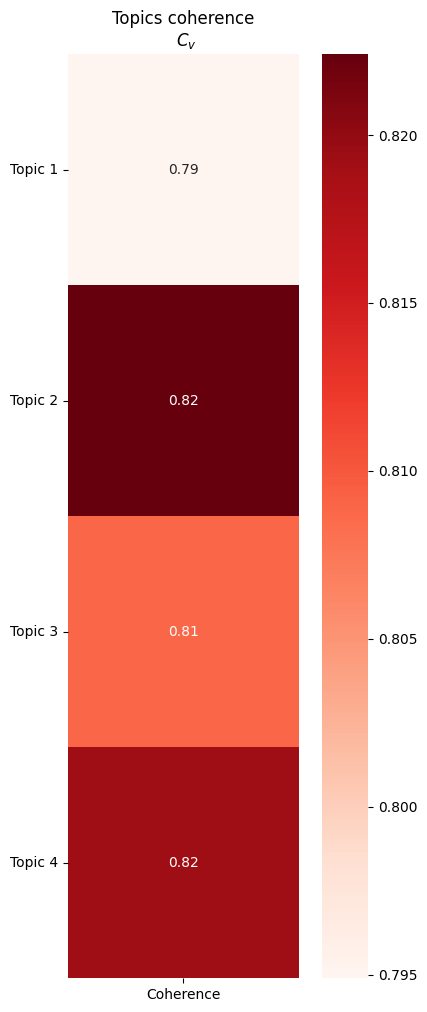

In [26]:
#plotting result
import seaborn as sns

topics_str = ['Topic 1','Topic 2','Topic 3','Topic 4']
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(6,12) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

In [27]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_model, tfidf_matrix, tfidf_model)


c:\Users\nisha\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.009355 -0.027277       1        1  52.447847
1     -0.024182 -0.042968       2        1  41.217327
2     -0.109783  0.040688       3        1   3.378648
0      0.124610  0.029556       4        1   2.956177, topic_info=          Term        Freq       Total Category  logprob  loglift
211    product  286.000000  286.000000  Default  30.0000  30.0000
40      client  211.000000  211.000000  Default  29.0000  29.0000
34    business  407.000000  407.000000  Default  28.0000  28.0000
184        new  204.000000  204.000000  Default  27.0000  27.0000
271  technical  195.000000  195.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
111      group    8.111651  100.076159   Topic4  -4.7881   1.0086
199       plan    9.985582  123.236812   Topic4  -4.5803   1.0083
61    customer   11.105084  190.398108   Topic4  -4.4740   0.6796
88    engineer    8.494464  147.152984   Topic4  -4.7420   0.6692
291     vision    7.884841  114.636531   Topic4  -4.8165   0.8444

[213 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.449697             's
0         2  0.487807             's
0         3  0.057165             's
0         4  0.007622             's
2         1  0.428758        ability
...     ...       ...            ...
291       4  0.069786         vision
292       1  0.330065  visualization
292       2  0.649816  visualization
292       3  0.010315  visualization
292       4  0.010315  visualization

[605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])